![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Open_Source/14.01.SpanBertCoref.ipynb)

# **SpanBertCoref**

This notebook covers `SpanBertCoref`, a coreference resolution model based on [SpanBert](https://arxiv.org/abs/1907.10529), which identifies expressions that refer to the same entity in a text.    



<br/>


**📖 Learning Objectives:**

1. Understand how `SpanBertCoref` algorithm works.

2. Understand how `SpanBertCoref` follows an unsupervised approach which builds upon features extracted from the text.

3. Become comfortable using the different parameters of the annotator.


**🔗 Helpful Links:**

- Documentation : [SpanBertCoref](https://nlp.johnsnowlabs.com/docs/en/transformers#spanbertcoref)

- Python Docs : [SpanBertCoref](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/coref/spanbert_coref/index.html#sparknlp.annotator.coref.spanbert_coref.SpanBertCorefModel)

- Scala Docs : [SpanBertCoref](https://nlp.johnsnowlabs.com/api/com/johnsnowlabs/nlp/annotators/coref/SpanBertCorefModel.html)

- For extended examples of usage, see the [Spark NLP Workshop repository](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/annotation/english/coreference-resolution/Coreference_Resolution_SpanBertCorefModel.ipynb).

- Academic Reference Paper: [SpanBERT: Improving Pre-training by Representing and Predicting Spans](https://arxiv.org/abs/1907.10529)

- John Snow Labs [SpanBertCoref Model](https://nlp.johnsnowlabs.com/2022/06/14/spanbert_base_coref_en_3_0.html)

## **📜 Background**

SpanBERT is a pre-training method that is designed to better represent
and predict spans of text. A coreference resolution model is expected to identify expressions which refer to the same entity in a text.    

For example, given a sentence "John told Mary he would like to borrow a book from her.", the model will link "he" to "John" and "her" to "Mary".



## **🎬 Colab Setup**

In [ ]:
!pip install -q pyspark==3.1.2  spark-nlp==4.2.4

In [2]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml import PipelineModel

spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.2.4
Apache Spark version: 3.1.2


## **🖨️ Input/Output Annotation Types**

- Input: `DOCUMENT`, `TOKEN`

- Output: `DEPENDENCY`

## **🔎 Parameters**

- `setCaseSensitive` (BooleanParam): Whether to ignore case in index lookups (Default depends on model).

- `setConfigProtoBytes` (IntArrayParam): ConfigProto from tensorflow, serialized into byte array.

- `setDimension` (IntParam): Number of embedding dimensions (Default depends on model).

- `setEngine` (Param[String]): This param is set internally once via loadSavedModel.

- `setMaxSegmentLength` (IntParam): Max segment length to process (Read-only, depends on model).

- `setMaxSentenceLength` (IntParam): Max sentence length to process (Default: 128).

- `setSignatures` (MapFeature[String, String]): It contains TF model signatures for the laded saved model.

- `setStorageRef` (Param[String]): Unique identifier for storage (Default: this.uid).

- `setTextGenre` (Param[String]): Text genre, one of the following values: bc: Broadcast conversation, default bn: Broadcast news nw: News wire pt: Pivot text: Old Testament and New Testament text tc: Telephone conversation wb: Web data.

- `setVocabulary` (MapFeature[String, Int]): Vocabulary used to encode the words to ids with WordPieceEncoder.

Please check [Unraveling Coreference Resolution in NLP!](https://towardsai.net/p/nlp/c-r) for the examples and explanations below.

## **💻 SpanBertCoref Pipeline**


In [3]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
sentencer = SentenceDetector()\
    .setInputCols(["document"]) \
    .setOutputCol("sentences")

tokenizer = Tokenizer()\
     .setInputCols(["sentences"])\
     .setOutputCol("tokens")

corefResolution = SpanBertCorefModel()\
     .pretrained("spanbert_base_coref")\
     .setInputCols(["sentences", "tokens"])\
     .setOutputCol("corefs")

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, corefResolution])

data = spark.createDataFrame([["Ana is a Graduate Student at UT Dallas. She loves working in Natural Language Processing at the Institute. Her hobbies include blogging, dancing and singing."]]).toDF("text")

model = pipeline.fit(data)

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [4]:
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-----+------------------------------------------------------------------------------------+
|token|metadata                                                                            |
+-----+------------------------------------------------------------------------------------+
|Ana  |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}|
|She  |{head.sentence -> 0, head -> Ana, head.begin -> 0, head.end -> 2, sentence -> 1}    |
|Her  |{head.sentence -> 0, head -> Ana, head.begin -> 0, head.end -> 2, sentence -> 2}    |
+-----+------------------------------------------------------------------------------------+



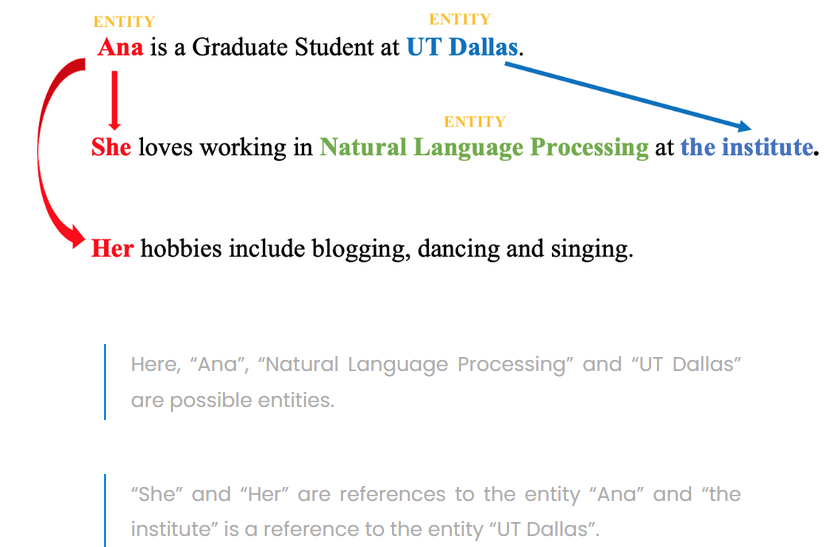

<br/>

**`extractParamMap`** will give us the details about the parameters of the SpanBertCorefModel. 

In [ ]:
corefResolution.extractParamMap()

{Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='engine', doc='Deep Learning engine used for this model'): 'tensorflow',
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='storageRef', doc='unique reference name for identification'): 'SPANBERTCOREFMODEL_20b2660eea55',
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='textGenre', doc="Text genre, one of ('bc', 'bn', 'mz', 'nw', 'pt','tc', 'wb')"): 'bc',
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='maxSentenceLength', doc='Max sentence length to process'): 512,
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='caseSensitive', doc='whether to ignore case in tokens for embeddings matching'): True,
 Param(parent='SPANBERTCOREFMODEL_20b2660eea55', name='inputCols', doc='previous annotations columns, if renamed'): ['sentences',
  'tokens'],
 Param(parent='SPANBERTCOR

## `setCaseSensitive`

In [ ]:
corefResolution = SpanBertCorefModel()\
     .pretrained("spanbert_base_coref")\
     .setInputCols(["sentences", "tokens"])\
     .setOutputCol("corefs")\
     .setCaseSensitive(False)

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, corefResolution])

data = spark.createDataFrame([["Ana is a Graduate Student at UT Dallas. She loves working in Natural Language Processing at the Institute. Her hobbies include blogging, dancing and singing."]]).toDF("text")

model = pipeline.fit(data)

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [ ]:
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-------------+----------------------------------------------------------------------------------------+
|token        |metadata                                                                                |
+-------------+----------------------------------------------------------------------------------------+
|ana          |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}    |
|she          |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 1}        |
|her          |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 2}        |
|ut dallas    |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}    |
|the institute|{head.sentence -> 0, head -> ut dallas, head.begin -> 29, head.end -> 37, sentence -> 1}|
+-------------+----------------------------------------------------------------------------------------+



Setting the `CaseSensitive` parameter to **False** increased the produced tokens. In the original case, **UT Dallas** was not considered as an entity.

## `setMaxSentenceLength`

In [ ]:
corefResolution = SpanBertCorefModel()\
     .pretrained("spanbert_base_coref")\
     .setInputCols(["sentences", "tokens"])\
     .setOutputCol("corefs")\
     .setCaseSensitive(False)\
     .setMaxSentenceLength(6)

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, corefResolution])

data = spark.createDataFrame([["Ana is a Graduate Student at UT Dallas. She loves working in Natural Language Processing at the Institute. Her hobbies include blogging, dancing and singing."]]).toDF("text")

model = pipeline.fit(data)

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [ ]:
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-----+------------------------------------------------------------------------------------+
|token|metadata                                                                            |
+-----+------------------------------------------------------------------------------------+
|ana  |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}|
|she  |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 1}    |
|her  |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 2}    |
+-----+------------------------------------------------------------------------------------+



Setting the `MaxSentenceLength` parameter to a low value of **6** decreased the produced tokens. **UT Dallas** and **the Institute** were the 9th and 10th words and they were not detected due to the specified limit.

## `maxSegmentLength`

This parameter provides the option to limit the number of characters that will be considered.

In [ ]:
corefResolution = SpanBertCorefModel()\
     .pretrained("spanbert_base_coref")\
     .setInputCols(["sentences", "tokens"])\
     .setOutputCol("corefs")\
     .setCaseSensitive(True)\
     .setMaxSentenceLength(512)\
     .setMaxSegmentLength(50)

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, corefResolution])

data = spark.createDataFrame([["Ana is a Graduate Student at UT Dallas. She loves working in Natural Language Processing at the Institute. Her hobbies include blogging, dancing and singing."]]).toDF("text")

model = pipeline.fit(data)

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [ ]:
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-----+------------------------------------------------------------------------------------+
|token|metadata                                                                            |
+-----+------------------------------------------------------------------------------------+
|Ana  |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}|
|She  |{head.sentence -> 0, head -> Ana, head.begin -> 0, head.end -> 2, sentence -> 1}    |
|Her  |{head.sentence -> 0, head -> Ana, head.begin -> 0, head.end -> 2, sentence -> 2}    |
+-----+------------------------------------------------------------------------------------+



<br/>

Lowering `MaxSegmentLength` caused the model fail to pick UT Dallas. 

Remember, the default value is 384 and "UT Dallas" and "the institute" entities are at the end of the sentences.

<br/>

`setTextGenre`

<br/>

For the `setTextGenre`, one of the following values may be selected: bc: Broadcast conversation (default); bn: Broadcast news; nw: News wire; pt: Pivot text - Old Testament and New Testament; tc: Telephone conversation; wb: Web data. 

In [ ]:
corefResolution = SpanBertCorefModel()\
     .pretrained("spanbert_base_coref")\
     .setInputCols(["sentences", "tokens"])\
     .setOutputCol("corefs")\
     .setCaseSensitive(False)\
     .setMaxSentenceLength(512)\
     .setMaxSegmentLength(384)\
     .setTextGenre('tc')

pipeline = Pipeline(stages=[documenter, sentencer, tokenizer, corefResolution])

data = spark.createDataFrame([["Ana is a Graduate Student at UT Dallas. She loves working in Natural Language Processing at the Institute. Her hobbies include blogging, dancing and singing."]]).toDF("text")

model = pipeline.fit(data)

spanbert_base_coref download started this may take some time.
Approximate size to download 540.1 MB
[OK!]


In [ ]:
model.transform(data).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+-------------+----------------------------------------------------------------------------------------+
|token        |metadata                                                                                |
+-------------+----------------------------------------------------------------------------------------+
|ana          |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}    |
|she          |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 1}        |
|her          |{head.sentence -> 0, head -> ana, head.begin -> 0, head.end -> 2, sentence -> 2}        |
|ut dallas    |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}    |
|the institute|{head.sentence -> 0, head -> ut dallas, head.begin -> 29, head.end -> 37, sentence -> 1}|
+-------------+----------------------------------------------------------------------------------------+



### Example # 2

This example is a little more complicated. The very last token was **The 49 year old** and it shows that the model was quite capable in detecting it, although it was not a simple pronoun.

In [ ]:
data_2 = spark.createDataFrame([["Elon Musk was born on June 28, 1971. He is the founder, CEO , chief engineer and designer of SpaceX. The 49 year old is widely known as the mind behind Neuralink."]]).toDF("text")

model = pipeline.fit(data_2)

In [ ]:
model.transform(data_2).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+---------------+--------------------------------------------------------------------------------------+
|token          |metadata                                                                              |
+---------------+--------------------------------------------------------------------------------------+
|Elon Musk      |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0}  |
|He             |{head.sentence -> 0, head -> Elon Musk, head.begin -> 0, head.end -> 8, sentence -> 1}|
|The 49 year old|{head.sentence -> 0, head -> Elon Musk, head.begin -> 0, head.end -> 8, sentence -> 2}|
+---------------+--------------------------------------------------------------------------------------+



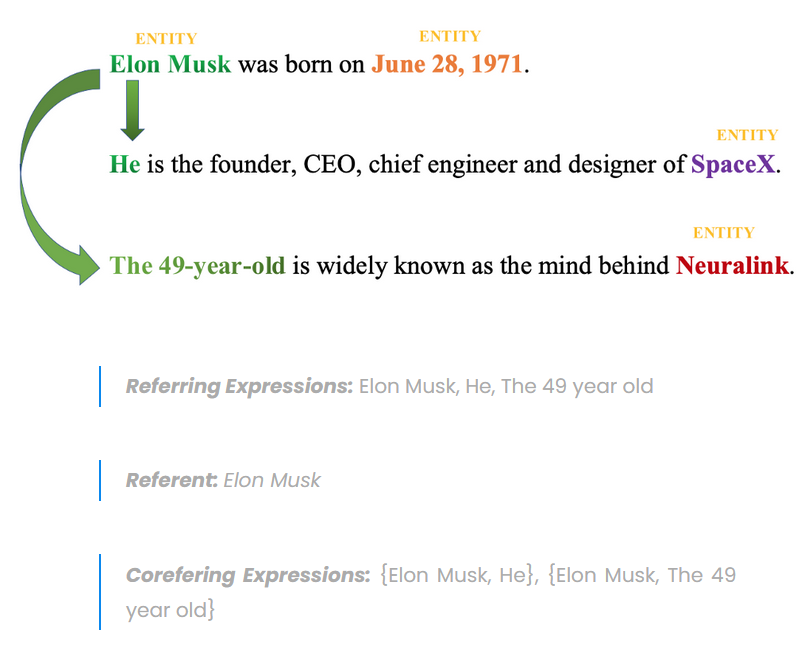

### Example # 3

This example is much longer and more complicated. The paragraph involves a person and a company's names mentioned in multiple ways and the model was able to detect them all.

In [ ]:
data_3 = spark.createDataFrame([[""" "I had no idea I was getting in so deep," says Mr. Kaye, who founded Justin in 1982. Mr. Kaye had sold Capetronic Inc., a Taiwan electronics maker, and retired, only to find he was bored. With Justin, he began selling toys and electronics made mostly in Hong Kong, beginning with Mickey Mouse radios. The company has grown - to about 40 employees, from four initially, Mr Kaye says. Justin has been profitable since 1986."""]]).toDF("text")

model = pipeline.fit(data_3)

In [ ]:
model.transform(data_3).selectExpr("explode(corefs) AS coref").selectExpr("coref.result as token", "coref.metadata").show(truncate=False)

+--------------------------------------+-------------------------------------------------------------------------------------+
|token                                 |metadata                                                                             |
+--------------------------------------+-------------------------------------------------------------------------------------+
|I                                     |{head.sentence -> -1, head -> ROOT, head.begin -> -1, head.end -> -1, sentence -> 0} |
|I                                     |{head.sentence -> 0, head -> I, head.begin -> 2, head.end -> 2, sentence -> 0}       |
|Mr . Kaye , who founded Justin in 1982|{head.sentence -> 0, head -> I, head.begin -> 2, head.end -> 2, sentence -> 0}       |
|Mr . Kaye                             |{head.sentence -> 0, head -> I, head.begin -> 2, head.end -> 2, sentence -> 1}       |
|he                                    |{head.sentence -> 0, head -> I, head.begin -> 2, head.end -> 2, sentenc

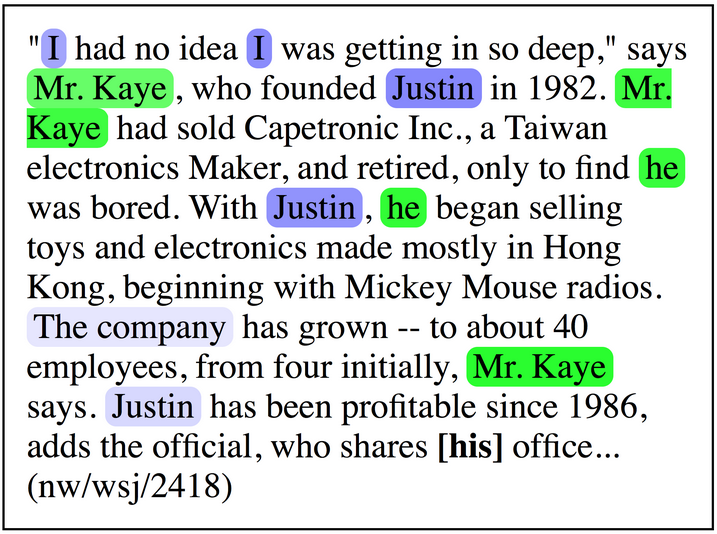